# Submission

In this notebook, we use an existing ResNet model with stretched images to correctly classify with high accuracy whether an image contains an invasive species of hydrangea on the test set.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

import timeit
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install kaggle-cli

## Load Datasets

We load the Invasive Species Dataset. It assumes the dataset is stored according to format of an ImageFolder dataset.

In [25]:
from torchvision import models, transforms
from KaggleImageFolder import KaggleImageFolder
import os
from ScaleSquareTransform import ScaleSquare
cwd = os.getcwd()

data_transforms = {
    'test_folder': transforms.Compose([
        ScaleSquare(224),
        transforms.ToTensor(),
    ])
}

data_dir = os.path.join(cwd,"dataset")
dset = KaggleImageFolder(os.path.join(data_dir, 'test_folder'), data_transforms['test_folder'])
dset_loader = torch.utils.data.DataLoader(dset, batch_size=1, shuffle=True, num_workers=1)

dset_size = len(dset)
print_every = 100
model_save_dir = os.path.join(cwd,"model_params_scaling.pth")

## Image sample
Plot an image just to make sure we have something that makes sense.

In [17]:
import torchvision.utils
import matplotlib.pyplot as plt

to_pil = torchvision.transforms.ToPILImage()

def show_img(inp):
    print(inp.size())
    img = to_pil(inp)
    plt.imshow(img)

torch.Size([3, 224, 224])


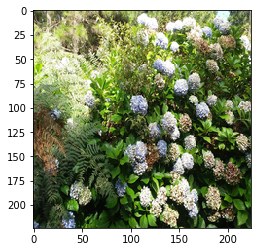

In [20]:
inputs, classes = next(iter(dset_loader))
show_img(inputs[0])

In [21]:
# Verify that CUDA is properly configured and you have a GPU available
gpu_dtype = torch.cuda.FloatTensor
torch.cuda.is_available()

True

## Test the model!

In [61]:
import csv
def create_submission_file(name, name_to_pred):
    with open(name+'.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(['name','invasive'])
        for key, value in name_to_pred.items():
            writer.writerow([key, value])

In [58]:
def compute_test_results(model, loader):
    print('Checking accuracy on test set')   
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    name_to_pred = {}
    for x, full_path in loader:
        x_var = Variable(x.type(gpu_dtype), volatile=True)
        scores = model(x_var)
        z, preds = scores.data.cpu().max(1)
        path = os.path.basename(full_path[0]).split('.jpg')[0]
        name_to_pred[path] = preds[0,0]
    return name_to_pred

In [27]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.cuda()
model.load_state_dict(torch.load(model_save_dir))

In [59]:
name_to_pred = compute_test_results(model, dset_loader)

Checking accuracy on test set


In [62]:
create_submission_file("tests/test0", name_to_pred)

In [75]:
from TestModel import TestModel

TestModel(model).submit()

File available at test0.csv
